# Use Deep Learning to Clone Driving Behavior

## Submission criterias

### Quality of Code
- Is the code functional?
    - TODO The model provided can be used to successfully operate the simulation.
- Is the code usable and readable?
    - TODO The code in model.py uses a Python generator, if needed, to generate data for training rather than storing the training data in memory. 
    - TODO: The model.py code is clearly organized and comments are included where needed.
    
### Model Architecture and Training Strategy
- Has an appropriate model architecture been employed for the task?
    * TODO: The neural network uses convolution layers with appropriate filter sizes. 
    * TODO: Layers exist to introduce nonlinearity into the model. 
    * TODO: The data is normalized in the model.
    
- Has an attempt been made to reduce overfitting of the model?
    - TODO: Train/validation/test splits have been used, and the model uses dropout layers or other methods to reduce overfitting.
- Have the model parameters been tuned appropriately?
    - TODO: Learning rate parameters are chosen with explanation, or an Adam optimizer is used.
- Is the training data chosen appropriately?
    - TODO: Training data has been chosen to induce the desired behavior in the simulation (i.e. keeping the car on the track).
    
### Architecture and Training Documentation
- Is the solution design documented?
    - The README thoroughly discusses the approach taken for deriving and designing a model architecture fit for solving the given problem.
- Is the model architecture documented?
    - The README provides sufficient details of the characteristics and qualities of the architecture, such as the type of model used, the number of layers, the size of each layer. Visualizations emphasizing particular qualities of the architecture are encouraged.
- Is the creation of the training dataset and training process documented?
    - The README describes how the model was trained and what the characteristics of the dataset are. Information such as how the dataset was generated and examples of images from the dataset should be included.
    
### Simulation
- Is the car able to navigate correctly on test data?
    - No tire may leave the drivable portion of the track surface. The car may not pop up onto ledges or roll over any surfaces that would otherwise be considered unsafe (if humans were in the vehicle).

### Objective to building model
The goal is the car to drive within the lane lines, so the model needs to recognise lane lines from the camera images.
TODO: Copy the Nvidia pipeline. It works :) And it's not too complex.

### Preprocessing
Re-size the input image. I was able to size the image down by 2, reducing the number of pixels by 4. This really helped speed up model training and did not seem to impact the accuracy.

### Warning!
drive.py sends RGB images to the model; cv2.imread() reads images in BGR format!!!!
Fixed the bug and passed the 2 sharp corners at the first attempt lol.


### Starting out

##### Train 3 images 
When you're starting out, pick three images from the .csv file, one with negative steering, one with straight, and one with right steering. Train a model with just those three images and see if you can get it to predict them correctly. This will tell you that your model is good and your turn-around time will be very quick. Then you can start adding more training data

##### Train on provided data 
There is 8037 snapshots provided in the training set. Use it to train the network. 


Here is [Github project](https://github.com/vxy10/P3-BehaviorCloning) of Vivek Yadav [post 1](https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9#.vbfk0tp2p) and [post 2](https://chatbotslife.com/learning-human-driving-behavior-using-nvidias-neural-network-model-and-image-augmentation-80399360efee#.xrn3giarp)

Try out [Comma.ai model](https://github.com/commaai/research/blob/master/train_steering_model.py)



## TODO: provide correct model without dropouts

we choose ELU() over ReLu because ELUs have [improved learning characteristics](https://arxiv.org/pdf/1511.07289v1.pdf) compared to the units with other activation functions. In contrast to ReLUs, ELUs have negative values which allows them to push mean unit activations closer to zero.

In [ ]:
NVIDIA_H, NVIDIA_W = 66, 200

CONFIG = {
    'batchsize': 512,
    'input_width': NVIDIA_W,
    'input_height': NVIDIA_H,
    'input_channels': 3,
    'delta_correction': 0.25,
    'augmentation_steer_sigma': 0.2,
    'augmentation_value_min': 0.2,
    'augmentation_value_max': 1.5,
    'bias': 0.8,
    'crop_height': range(20, 140)
}

def get_nvidia_model(summary=True):
    init = 'glorot_uniform'

    input_frame = Input(shape=(66, 200, 3))

    # input normalization
    ''' The first layer of the network performs image normalization. The normalizer is hard-coded 
    and is not adjusted in the learning process. 
    Performing normalization in the network allows the normalization scheme to be altered with 
    the network architecture, and to be accelerated via GPU processing.'''
    x = Lambda(lambda z: z / 127.5 - 1.)(input_frame)

    ''' The convolutional layers are designed to perform feature extraction, and are chosen empirically 
    through a series of experiments that vary layer configurations. 
    We then use strided convolutions in the first three convolutional layers with a 2×2 stride and a 5×5 kernel'''
    x = Convolution2D(24, 5, 5, border_mode='valid', subsample=(2, 2), init=init)(x)
    x = ELU()(x)
    x = Dropout(0.2)(x)
    x = Convolution2D(36, 5, 5, border_mode='valid', subsample=(2, 2), init=init)(x)
    x = ELU()(x)
    x = Dropout(0.2)(x)
    x = Convolution2D(48, 5, 5, border_mode='valid', subsample=(2, 2), init=init)(x)
    x = ELU()(x)
    x = Dropout(0.2)(x)
    
    '''We use a non-strided convolution with a 3×3 kernel size in the final two convolutional layers.'''
    x = Convolution2D(64, 3, 3, border_mode='valid', init=init)(x)
    x = ELU()(x)
    x = Dropout(0.2)(x)
    x = Convolution2D(64, 3, 3, border_mode='valid', init=init)(x)
    x = ELU()(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    
    ''' We follow the five convolutional layers with three fully connected layers, leading to a final 
    output control value which is the inverse-turning-radius. 
    The fully connected layers are designed to function as a controller for steering, but we noted 
    that by training the system end-to-end, it is not possible to make a clean break between which 
    parts of the network function primarily as feature extractor, and which serve as controller.'''
    x = Dense(1164, init=init)(x)
    x = ELU()(x)    
    x = Dropout(0.5)(x)

    x = Dense(100, init=init)(x)
    x = ELU()(x)    
    x = Dropout(0.5)(x)
    
    x = Dense(50, init=init)(x)
    x = ELU()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(10, init=init)(x)
    x = ELU()(x)
    
    out = Dense(1, init=init)(x)

    model = Model(input=input_frame, output=out)

    if summary:
        model.summary()

    return model


In [ ]:
model = get_nvidia_model(False)

## Data visualization

In [73]:
def visualize_steering_distribution(train_data):
    """
    Visualize the training ground truth distribution "as provided"
    :param train_data: list of udacity training data
    :return:
    """
    train_steering = np.float32(np.array(train_data)[:, 3])
    plt.title('Steering angle distribution in training data')
    plt.hist(train_steering, 100, normed=0, facecolor='green', alpha=0.75)
    plt.ylabel('# frames'), plt.xlabel('steering angle')
    plt.show()


def visualize_bias_parameter_effect(train_data):
    """
    Visualize how the 'bias' parameter influences the ground truth distribution
    :param train_data:
    :return:
    """
    biases = np.linspace(start=0., stop=1., num=5)
    fig, axarray = plt.subplots(len(biases))
    plt.suptitle('Effect of bias parameter on steering angle distribution', fontsize=14, fontweight='bold')
    for i, ax in enumerate(axarray.ravel()):
        b = biases[i]
        x_batch, y_batch = load_data_batch(train_data, batchsize=1024, augment_data=True, bias=b)
        ax.hist(y_batch, 50, normed=1, facecolor='green', alpha=0.75)
        ax.set_title('Bias: {:02f}'.format(b))
        ax.axis([-1., 1., 0., 2.])
    plt.tight_layout(pad=2, w_pad=0.5, h_pad=1.0)
    plt.show()


In [ ]:
# NVIDIA model
import cv2
import csv
import random
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import keras.backend as K
from keras.optimizers import Adam
from keras.layers import Input, Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, ELU, Lambda
from keras.models import Model
from keras.callbacks import ModelCheckpoint, CSVLogger

NVIDIA_H, NVIDIA_W = 66, 200

CONFIG = {
    'batchsize': 512,
    'input_width': NVIDIA_W,
    'input_height': NVIDIA_H,
    'input_channels': 3,
    'delta_correction': 0.25,
    'augmentation_steer_sigma': 0.2,
    'augmentation_value_min': 0.2,
    'augmentation_value_max': 1.5,
    'bias': 0.8,
    'crop_height': range(20, 140)
}

def get_nvidia_model(summary=True):
    init = 'glorot_uniform'

    input_frame = Input(shape=(66, 200, 3))

    # input normalization
    ''' The first layer of the network performs image normalization. The normalizer is hard-coded 
    and is not adjusted in the learning process. 
    Performing normalization in the network allows the normalization scheme to be altered with 
    the network architecture, and to be accelerated via GPU processing.'''
    x = Lambda(lambda z: z / 127.5 - 1.)(input_frame)

    ''' The convolutional layers are designed to perform feature extraction, and are chosen empirically 
    through a series of experiments that vary layer configurations. 
    We then use strided convolutions in the first three convolutional layers with a 2×2 stride and a 5×5 kernel'''
    x = Convolution2D(24, 5, 5, border_mode='valid', subsample=(2, 2), init=init)(x)
    x = ELU()(x)
    x = Dropout(0.2)(x)
    x = Convolution2D(36, 5, 5, border_mode='valid', subsample=(2, 2), init=init)(x)
    x = ELU()(x)
    x = Dropout(0.2)(x)
    x = Convolution2D(48, 5, 5, border_mode='valid', subsample=(2, 2), init=init)(x)
    x = ELU()(x)
    x = Dropout(0.2)(x)
    
    '''We use a non-strided convolution with a 3×3 kernel size in the final two convolutional layers.'''
    x = Convolution2D(64, 3, 3, border_mode='valid', init=init)(x)
    x = ELU()(x)
    x = Dropout(0.2)(x)
    x = Convolution2D(64, 3, 3, border_mode='valid', init=init)(x)
    x = ELU()(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    
    ''' We follow the five convolutional layers with three fully connected layers, leading to a final 
    output control value which is the inverse-turning-radius. 
    The fully connected layers are designed to function as a controller for steering, but we noted 
    that by training the system end-to-end, it is not possible to make a clean break between which 
    parts of the network function primarily as feature extractor, and which serve as controller.'''
    x = Dense(1164, init=init)(x)
    x = ELU()(x)    
    x = Dropout(0.5)(x)

    x = Dense(100, init=init)(x)
    x = ELU()(x)    
    x = Dropout(0.5)(x)
    
    x = Dense(50, init=init)(x)
    x = ELU()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(10, init=init)(x)
    x = ELU()(x)
    
    out = Dense(1, init=init)(x)

    model = Model(input=input_frame, output=out)

    if summary:
        model.summary()

    return model

def preprocess(frame_bgr, verbose=False):
    # set training images resized shape
    h, w = CONFIG['input_height'], CONFIG['input_width']

    # crop image (remove useless information)
    frame_cropped = frame_bgr[CONFIG['crop_height'], :, :]

    # resize image
    frame_resized = cv2.resize(frame_cropped, dsize=(w, h))

    # eventually change color space
    if CONFIG['input_channels'] == 1:
        frame_resized = np.expand_dims(cv2.cvtColor(frame_resized, cv2.COLOR_BGR2YUV)[:, :, 0], 2)

    if verbose:
        plt.figure(1), plt.imshow(cv2.cvtColor(frame_bgr, code=cv2.COLOR_BGR2RGB))
        plt.figure(2), plt.imshow(cv2.cvtColor(frame_cropped, code=cv2.COLOR_BGR2RGB))
        plt.figure(3), plt.imshow(cv2.cvtColor(frame_resized, code=cv2.COLOR_BGR2RGB))
        plt.show()

    return frame_resized.astype('float32')


def load_data_batch(data, batchsize=CONFIG['batchsize'], data_dir='data', augment_data=True, bias=0.5):
    # set training images resized shape
    h, w, c = CONFIG['input_height'], CONFIG['input_width'], CONFIG['input_channels']

    # prepare output structures
    X = np.zeros(shape=(batchsize, h, w, c), dtype=np.float32)
    y_steer = np.zeros(shape=(batchsize,), dtype=np.float32)
    y_throttle = np.zeros(shape=(batchsize,), dtype=np.float32)

    # shuffle data
    shuffled_data = shuffle(data)

    loaded_elements = 0
    while loaded_elements < batchsize:
        ct_path, lt_path, rt_path, steer, throttle, brake, speed = shuffled_data.pop()

        # cast strings to float32
        steer = np.float32(steer)
        throttle = np.float32(throttle)
        '''
        One predominant problem in steering prediction is that even if the model predicts really really well, 
        the model is bound to make a non zero error on it’s prediction. This means that over time the model 
        will drift off from center. Since we are only training the model to drive correctly and not training 
        the model how to recover (something that we humans know instinctively), the model is handicapped.

        To offset this problem, we choose images randomly between left, right or center images by doing 
        the following. The approach is to add / subtract a static offset from the angle when choosing 
        the left / right image. To get a smoother drive, we can add / subtract an offset that’s weighted 
        by the magnitude of the angle. But this biases the model towards zeros again and is a design tradeoff. 
        I chose the simple static offsets. This simulates the model drifting off the center and trains the model 
        to recover from it’s mistakes. This also gives us a lot more data to work with than by just using the 
        center images alone.
        img_choice = np.random.randint(3)
        if img_choice == 0:
            img_path = os.path.join(PATH, df.left.iloc[idx].strip())
            angle += OFF_CENTER_IMG
        elif img_choice == 1:
            img_path = os.path.join(PATH, df.center.iloc[idx].strip())
        else:
            img_path = os.path.join(PATH, df.right.iloc[idx].strip())
            angle -= OFF_CENTER_IMG
        '''
        # randomly choose which camera to use among (central, left, right)
        # in case the chosen camera is not the frontal one, adjust steer accordingly
        delta_correction = CONFIG['delta_correction']
        camera = random.choice(['frontal', 'left', 'right'])
        if camera == 'frontal':
            frame = preprocess(cv2.imread(join(data_dir, ct_path.strip())))
            steer = steer
        elif camera == 'left':
            frame = preprocess(cv2.imread(join(data_dir, lt_path.strip())))
            steer = steer + delta_correction
        elif camera == 'right':
            frame = preprocess(cv2.imread(join(data_dir, rt_path.strip())))
            steer = steer - delta_correction

        if augment_data:
            '''One easy way to get more data is to just flip the image around the horizontal axis 
            and flip the sign on the angle as well. We instantly get twice the data and we don’t 
            inadvertently bias the model towards any one direction.
            if np.random.randint(2) == 0:
                img = np.fliplr(img)
                new_angle = -new_angle
            '''
            # mirror images with chance=0.5
            if random.choice([True, False]):
                frame = frame[:, ::-1, :]
                steer *= -1.
                
            # perturb slightly steering direction
            steer += np.random.normal(loc=0, scale=CONFIG['augmentation_steer_sigma'])
            # if color images, randomly change brightness
            if CONFIG['input_channels'] == 3:
                frame = cv2.cvtColor(frame, code=cv2.COLOR_BGR2HSV)
                frame[:, :, 2] *= random.uniform(CONFIG['augmentation_value_min'], CONFIG['augmentation_value_max'])
                frame[:, :, 2] = np.clip(frame[:, :, 2], a_min=0, a_max=255)
                frame = cv2.cvtColor(frame, code=cv2.COLOR_HSV2BGR)
        # check that each element in the batch meet the condition
        steer_magnitude_thresh = np.random.rand()
        if (abs(steer) + bias) < steer_magnitude_thresh:
            pass  # discard this element
        else:
            X[loaded_elements] = frame
            y_steer[loaded_elements] = steer
            loaded_elements += 1

    if K.backend() == 'theano':
        X = X.transpose(0, 3, 1, 2)

    return X, y_steer


def generate_data_batch(data, batchsize=CONFIG['batchsize'], data_dir='data', augment_data=True, bias=0.5):
    # set training images resized shape
    h, w, c = CONFIG['input_height'], CONFIG['input_width'], CONFIG['input_channels']

    while True:
        # prepare output structures
        X = np.zeros(shape=(batchsize, h, w, c), dtype=np.float32)
        y_steer = np.zeros(shape=(batchsize,), dtype=np.float32)
        y_throttle = np.zeros(shape=(batchsize,), dtype=np.float32)

        # shuffle data
        shuffled_data = shuffle(data)

        loaded_elements = 0
        while loaded_elements < batchsize:

            ct_path, lt_path, rt_path, steer, throttle, brake, speed = shuffled_data.pop()

            # cast strings to float32
            steer = np.float32(steer)
            throttle = np.float32(throttle)

            # randomly choose which camera to use among (central, left, right)
            # in case the chosen camera is not the frontal one, adjust steer accordingly
            delta_correction = CONFIG['delta_correction']
            camera = random.choice(['frontal', 'left', 'right'])
            if camera == 'frontal':
                frame = preprocess(cv2.imread(join(data_dir, ct_path.strip())))
                steer = steer
            elif camera == 'left':
                frame = preprocess(cv2.imread(join(data_dir, lt_path.strip())))
                steer = steer + delta_correction
            elif camera == 'right':
                frame = preprocess(cv2.imread(join(data_dir, rt_path.strip())))
                steer = steer - delta_correction

            if augment_data:

                # mirror images with chance=0.5
                if random.choice([True, False]):
                    frame = frame[:, ::-1, :]
                    steer *= -1.

                # perturb slightly steering direction
                steer += np.random.normal(loc=0, scale=CONFIG['augmentation_steer_sigma'])

                # if color images, randomly change brightness
                if CONFIG['input_channels'] == 3:
                    frame = cv2.cvtColor(frame, code=cv2.COLOR_BGR2HSV)
                    frame[:, :, 2] *= random.uniform(CONFIG['augmentation_value_min'], CONFIG['augmentation_value_max'])
                    frame[:, :, 2] = np.clip(frame[:, :, 2], a_min=0, a_max=255)
                    frame = cv2.cvtColor(frame, code=cv2.COLOR_HSV2BGR)

            # check that each element in the batch meet the condition
            steer_magnitude_thresh = np.random.rand()
            if (abs(steer) + bias) < steer_magnitude_thresh:
                pass  # discard this element
            else:
                X[loaded_elements] = frame
                y_steer[loaded_elements] = steer
                loaded_elements += 1

        if K.backend() == 'theano':
            X = X.transpose(0, 3, 1, 2)

        yield X, y_steer

        


def split_train_val(csv_driving_data):

    with open(csv_driving_data, 'r') as f:
        reader = csv.reader(f)
        driving_data = [row for row in reader][1:]

    train_data, val_data = train_test_split(driving_data, test_size=0.2, random_state=1)

    return train_data, val_data

### Main

#if __name__ == '__main__':
if (1 + 1 == 2):    
    train_data, val_data = split_train_val(csv_driving_data='data/driving_log.csv')
    x_batch, y_batch = load_data_batch(train_data)
    nvidia_net = get_nvidia_model(summary=True)
    opt = Adam(lr=1e-3)
    nvidia_net.compile(optimizer=opt, loss='mse')

    # json dump of model architecture
    with open('logs/model.json', 'w') as f:
        f.write(nvidia_net.to_json())

    checkpointer = ModelCheckpoint('checkpoints/weights.{epoch:02d}-{val_loss:.3f}.hdf5')
    logger = CSVLogger(filename='logs/history.csv')

    nvidia_net.fit_generator(generator=generate_data_batch(train_data, augment_data=True, bias=CONFIG['bias']),
                         samples_per_epoch=300*CONFIG['batchsize'],
                         nb_epoch=50,
                         validation_data=generate_data_batch(val_data, augment_data=False, bias=1.0),
                         nb_val_samples=100*CONFIG['batchsize'],
                         callbacks=[checkpointer, logger])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 66, 200, 3)    0                                            
____________________________________________________________________________________________________
lambda_8 (Lambda)                (None, 66, 200, 3)    0           input_4[0][0]                    
____________________________________________________________________________________________________
convolution2d_36 (Convolution2D) (None, 31, 98, 24)    1824        lambda_8[0][0]                   
____________________________________________________________________________________________________
elu_68 (ELU)                     (None, 31, 98, 24)    0           convolution2d_36[0][0]           
___________________________________________________________________________________________

# Project Behavioral Cloning
Objective of this project is to develop a deep neural network that will learn and mimic human driving. 

### Project files
- model.py - The script used to create and train the model.
- drive.py - The script to drive the car. 
- model.json - The model architecture.
- model.h5 - The model weights.
- README.md  - explains the structure of network and training approach.

## Solution
 
### Collecting data.
Collecting data on my own was very difficult considering that I was limited by use of keyboard to control the simulator. I tried many times to collect the data withoud a success. But this gave me a chance to understand how important is the process of collecting the training data. So, I've started with the data provided in the project. I've downloaded and unziped the csv file and images into the data directory.

### Loading data

In [ ]:
### Importing packages. 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import signal
import cv2
import math
from scipy.misc import imread

# Loading data
csv_path = 'data/driving_log.csv'
data_files_s = pd.read_csv(csv_path, 
    header = 0,                       
    names=['center','left','right','steer','throttle','break','speed'],
    index_col = False)
data_files_s['direction'] = pd.Series('s', index=data_files_s.index)
rev_steer_s = np.array(data_files_s.steer)

print('number of data files: ', len(data_files_s))

### Data stats + Plotting data distribution
As with all deep learning problems, the first step is to understand the data we are working with. The most important for us is the steering angle. Let's analyse it.

### Angle over time 

In [ ]:
# Putionlot angle over time distrib
FRAMES_PER_SECOND = 10
len_plt = len(data_files_s) / FRAMES_PER_SECOND 

def plot_x_over_time(x, length, label):
    rev = np.array(x,dtype=np.float32)
    t_s = np.arange(len(rev))
    x_s = np.array(x)
    y_s = rev
    sm_s = rev
    plt.rcParams["figure.figsize"]= [16, 9]
    plt.plot(t_s[0:len_plt],x_s[0:len_plt],'--',t_s[0:len_plt],y_s[0:len_plt]);
    plt.title(label +  ' over time')
    plt.xlabel('time')
    plt.ylabel(label)
    plt.show()
    
plot_x_over_time(data_files_s.steer, len_plt, 'steer')
# plot_x_over_time(data_files_s.speed, len_plt, 'speed')
# plot_x_over_time(data_files_s.throttle, len_plt, 'throttle')
# plot_x_over_time(data_files_s['break'], len_plt, 'breaks')


### Angle distribution 

In [ ]:
def visualize_steering_distribution(train_data):
    """
    Visualize the training ground truth distribution "as provided"
    :param train_data: list of udacity training data
    :return:
    """
    train_steering = np.float32(np.array(train_data.steer))
    plt.title('Steering angle distribution in training data')
    plt.hist(train_steering, 100, normed=0, facecolor='green', alpha=0.75)
    plt.ylabel('# frames'), plt.xlabel('steering angle')
    plt.show()
    
visualize_steering_distribution(data_files_s)    

We see that the dataset holds large number of zeros and very very few of all other data. This is definitely going to bias our model towards predicting 0s, if we go ahead as it is. So we really need to think about augmentation.
Augmentation helps us extract as much information from data as possible. We will generate additional data using the several data augmentation techniques.
Disclaimer: Big part of described below data augmentation techniques has been adapted from [this post](https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9#.717xcwyla).


### Reading images


In [38]:
MODEL_IMG_WIDTH = 200
MODEL_IMG_HEIGHT = 66

def read_image(file):
    # Readimage from file
    image = imread('data/' + file)
    return image

def crop_resize_image(image,new_size_col=MODEL_IMG_WIDTH,new_size_row=MODEL_IMG_HEIGHT):
    shape = image.shape
    # note: numpy arrays are (row, col)!
    image = image[math.floor(shape[0]/4):shape[0]-25, 0:shape[1]]
    image = cv2.resize(image,(new_size_col, new_size_row), interpolation=cv2.INTER_AREA)  
    return image


train image shape (160, 320, 3)
cropped image shape (66, 200, 3)


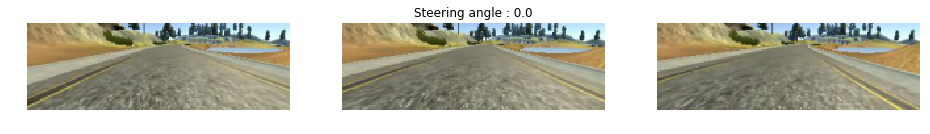

In [39]:
rev_steer_s = np.array(data_files_s.steer,dtype=np.float32)
steer_sm_s = rev_steer_s
data_files_s['steer_sm'] = pd.Series(steer_sm_s, index=data_files_s.index)

image_c = read_image(data_files_s['center'][0].strip())
TRAIN_IMG_HEIGHT, TRAIN_IMG_WIDTH, TRAIN_IMG_DEPTH = image_c.shape
print('train image shape',  image_c.shape)

croped_image = crop_resize_image(image_c)
print('cropped image shape',  croped_image.shape)

# Test out cropping out region of interest
ind_num = np.random.randint(len(data_files_s))

image_c = crop_resize_image(read_image(data_files_s['center'][ind_num].strip()))
image_r = crop_resize_image(read_image(data_files_s['right'][ind_num].strip()))
image_l = crop_resize_image(read_image(data_files_s['left'][ind_num].strip()))
plt.figure()
plt.subplot(1,3,1)
plt.imshow(image_l);
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(image_c);
plt.axis('off')
plt.title('Steering angle : '+ str(np.round(rev_steer_s[ind_num]*25,2) ));
plt.subplot(1,3,3)
plt.imshow(image_r);
plt.axis('off');

We see that original images are has dimension 320 by 160 but for our model we need a different size 200 by 66. OUr model will learn from the middle part of the image, so we'll cut the top and the bottom of the original image.

### Shifting images
We randomly shifted the camera images horizontally to simulate the effect of car being at different positions on the lane, and added an offset corresponding to the shift to the steering angle. ** A better solution could be generating a wide angle / panorama image and do several crops with an offset ** 

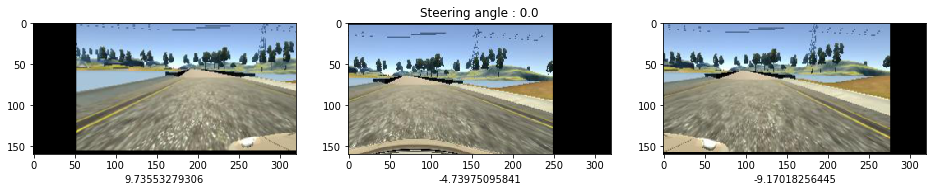

In [40]:
def trans_image(image, steer, trans_range):
    # Translation
    tr_x = trans_range * np.random.uniform() - trans_range / 2
    steer_ang = steer + tr_x/trans_range * 2 *.2
    tr_y = 10 * np.random.uniform() - 10 / 2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image, Trans_M, (320, 160))
    #print(steer, steer_ang,tr_x)
    return image_tr, steer_ang, tr_x

# Test translation
ind_num = np.random.randint(len(data_files_s))
angle = rev_steer_s[ind_num]
#print(angle, ind_num)
image_c, a_c, t_c = trans_image(read_image(data_files_s['center'][ind_num].strip()), angle, 150)
image_r, a_r, t_r = trans_image(read_image(data_files_s['right'][ind_num].strip()), angle -.25, 150)
image_l, a_l, t_l = trans_image(read_image(data_files_s['left'][ind_num].strip()), angle + .25, 150 )
plt.figure()
plt.subplot(1,3,1)
plt.xlabel(a_l * 25)
plt.imshow(image_l);
#plt.axis('off')
plt.subplot(1,3,2)
plt.xlabel(a_c * 25)
plt.imshow(image_c);
#plt.axis('off')
plt.title('Steering angle : '+ str(np.round(rev_steer_s[ind_num]*25,2) ));
plt.subplot(1,3,3)
plt.xlabel(a_r * 25)
plt.imshow(image_r);
#plt.axis('off');

### Brightness adjustment

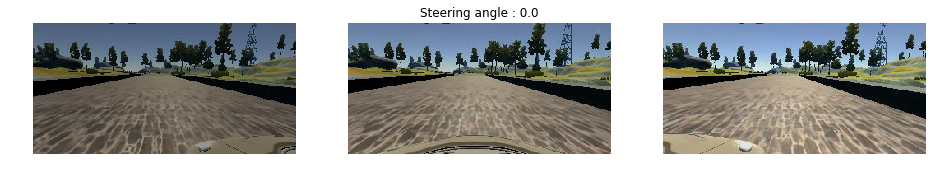

In [41]:
def augment_brightness(image):
    image1 = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    random_bright = .5 + np.random.uniform()
    if (random_bright > 1):
           random_bright = 1    
    #print(random_bright)
    image1[:,:,2] = image1[:,:,2] * random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

ind_num = np.random.randint(len(data_files_s))

image_c = augment_brightness(read_image(data_files_s['center'][ind_num].strip()))
image_r = augment_brightness(read_image(data_files_s['right'][ind_num].strip()))
image_l = augment_brightness(read_image(data_files_s['left'][ind_num].strip()))
plt.figure()
plt.subplot(1,3,1)
plt.imshow(image_l);
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(image_c);
plt.axis('off')
plt.title('Steering angle : '+ str(np.round(rev_steer_s[ind_num]*25,2) ));
plt.subplot(1,3,3)
plt.imshow(image_r);
plt.axis('off');

### Crop out region of interest and resize

train image shape (160, 320, 3)
cropped image shape (66, 200, 3)


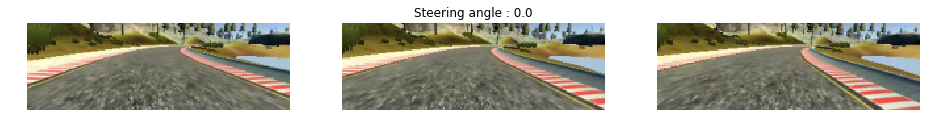

In [42]:
# Test out cropping out region of interest 
ind_num = np.random.randint(len(data_files_s))

image_c = read_image(data_files_s['center'][ind_num].strip())
rows, cols, channels = image_c.shape
print('train image shape',  image_c.shape)
croped_image = crop_resize_image(image_c)
print('cropped image shape',  croped_image.shape)

image_c = crop_resize_image(read_image(data_files_s['center'][ind_num].strip()))
image_r = crop_resize_image(read_image(data_files_s['right'][ind_num].strip()))
image_l = crop_resize_image(read_image(data_files_s['left'][ind_num].strip()))

plt.figure()
plt.subplot(1,3,1)
plt.imshow(image_l);
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(image_c);
plt.axis('off')
plt.title('Steering angle : '+ str(np.round(rev_steer_s[ind_num]*25,2) ));
plt.subplot(1,3,3)
plt.imshow(image_r);
plt.axis('off');

### Flipping images 
One easy way to get more data is to just flip the image around the horizontal axis and flip the sign on the angle as well. We instantly get twice the data and we don’t inadvertently bias the model towards any one direction.

### Test augmentation 

In [43]:

def preprocess_image_file_train(line_data):
    # Preprocessing training files and augmenting
    i_lrc = np.random.randint(3)
    if (i_lrc == 0):
        path_file = line_data['left'][0].strip()
        shift_ang = .25
    if (i_lrc == 1):
        path_file = line_data['center'][0].strip()
        shift_ang = 0.
    if (i_lrc == 2):
        path_file = line_data['right'][0].strip()
        shift_ang = -.25
        
    y_steer = line_data['steer_sm'][0] + shift_ang
    image = imread('data/' + path_file)
    
    image, y_steer, tr_x = trans_image(image, y_steer, 150)
    
    image = augment_brightness(image)
    
    image = crop_resize_image(image)
    image = np.array(image)
    
    ind_flip = np.random.randint(2)
    if ind_flip==0:
        image = cv2.flip(image,1)
        y_steer = -y_steer

    return image, y_steer


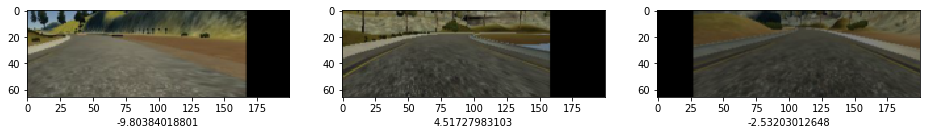

In [44]:
# Test augmentation
c = np.random.randint(len(data_files_s))
l_c = data_files_s.iloc[[c]].reset_index()
r = np.random.randint(len(data_files_s))
l_r = data_files_s.iloc[[r]].reset_index()
l = np.random.randint(len(data_files_s))
l_l = data_files_s.iloc[[l]].reset_index()

image_c, a_c = preprocess_image_file_train(l_c)
image_r, a_r = preprocess_image_file_train(l_r)
image_l, a_l = preprocess_image_file_train(l_l)

plt.figure()
plt.subplot(1,3,1)
plt.xlabel(a_l * 25)
plt.imshow(image_l);
plt.subplot(1,3,2)
plt.xlabel(a_c * 25)
plt.imshow(image_c);
plt.subplot(1,3,3)
plt.xlabel(a_r * 25)
plt.imshow(image_r);

## Model architecture


## Model architecture

We have chosen [NVIDIA model](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) 

<img src="https://devblogs.nvidia.com/parallelforall/wp-content/uploads/2016/08/cnn-architecture.png" width="400">

<p><center>NVIDIA model architecture, taken from [End to end learning for self-driving cars](https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf)</center>

We did not use dropouts or maxpooling in our architecture to remain true to NVIDIA model. 

We used exponential leaky units (ELU) for activation functions, because ELUs have smoother derivatives at zero, and hence are expected to be slighly better for predicted continuous values. We tested the model with rectified linear units (ReLU) too, and noticed minimal performance difference between the two networks.

In [61]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU
from keras.layers.convolutional import Convolution2D

def nvidia_model(summary=False):
    init = 'he_normal'
    model = Sequential()
    # TODO:  checkif we can do mean subtraction
    model.add(Lambda(lambda z: z / 127.5 - 1., input_shape=[MODEL_IMG_HEIGHT, MODEL_IMG_WIDTH, 3]))
    model.add(Convolution2D(24, 5, 5, border_mode='valid', subsample=(2, 2), init=init))
    model.add(ELU())
#    model.add(Dropout(0.2))
    model.add(Convolution2D(36, 5, 5, border_mode='valid', subsample=(2, 2), init=init))
    model.add(ELU())
#    model.add(Dropout(0.2))
    model.add(Convolution2D(48, 5, 5, border_mode='valid', subsample=(2, 2), init=init))
    model.add(ELU())
#    model.add(Dropout(0.2))
    model.add(Convolution2D(64, 3, 3, border_mode='valid', subsample=(1, 1), init=init))
    model.add(ELU())
#    model.add(Dropout(0.2))
    model.add(Convolution2D(64, 3, 3, border_mode='valid', subsample=(1, 1), init=init))
    model.add(ELU())
#    model.add(Dropout(0.2))
    model.add(Flatten())
#    model.add(Dropout(0.2))
    model.add(Dense(1164, init=init))
    model.add(ELU())
#    model.add(Dropout(0.5))
    model.add(Dense(100, init=init))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Dense(50, init=init))
    model.add(ELU())
    model.add(Dense(10, init=init))
    model.add(Dropout(0.5))
    model.add(ELU())
    model.add(Dense(1, init=init))
    model.add(ELU())

    if summary:
        model.summary()
    return model


In [62]:
model = nvidia_model()

### Keras generator and subsampling
Since most of the time the car is driving along straight line, it is highly likely that the car is biased toward going straight. To remove this bias, we need to subsampled data to drop small angles with probabilities. The drop probability will start high in the initial part, and will be reduced as training epochs progressed.

In [63]:
def generate_train_from_PD_batch(data, batch_size):
    ## Generator for keras training, with subsampling
    batch_images = np.zeros((batch_size, MODEL_IMG_HEIGHT, MODEL_IMG_WIDTH, 3))
    batch_steering = np.zeros(batch_size)
    while 1:
        for i in range(batch_size):
            rnd = np.random.randint(len(data))
            line_data = data.iloc[[rnd]].reset_index()
            keep_pr = 0
            while keep_pr == 0:
                img, angle = preprocess_image_file_train(line_data)
                pr_unif = np.random
                if abs(angle) < .15:
                    pr_val = np.random.uniform()
                    if pr_val > pr_threshold:
                        keep_pr = 1
                else:
                    keep_pr = 1
            batch_images[i] = img
            batch_steering[i] = angle
        yield batch_images, batch_steering


### Optimizer 
We've choosen Adam optimizer with a learning rate of 1e-4. This was empirically noted as we are transfer learning 
(fine tuning an existing model).


In [65]:
from keras.optimizers import Adam
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

# Compile model 
model.compile(optimizer=adam, loss='mse')

In [66]:
def preprocess_image_file_predict(line_data):
    # Preprocessing Prediction files and augmenting
    path_file = line_data['center'][0].strip()
    image = imread('data/' + path_file)
    image = crop_resize_image(image)
    image = np.array(image)
    return image

def generate_valid_from_PD(data):
    # Validation generator
    while 1:
        for i_line in range(len(data)):
            line_data = data.iloc[[i_line]].reset_index()
            #print(line_data)
            x = preprocess_image_file_predict(data)
            x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
            y = line_data['steer_sm'][0]
            y = np.array([[y]])
            yield x, y

def save_model(fileModelJSON, fileWeights):
    #print("Saving model to disk: ",fileModelJSON,"and",fileWeights)
    if Path(fileModelJSON).is_file():
        os.remove(fileModelJSON)
    json_string = model.to_json()
    with open(fileModelJSON,'w' ) as f:
        json.dump(json_string, f)
    if Path(fileWeights).is_file():
        os.remove(fileWeights)
    model.save_weights(fileWeights)
    
valid_s_generator = generate_valid_from_PD(data_files_s)

### Bias
We start with a bias of 1.0 (allow all angles) and slowly as the epochs continue, reduce the bias, thereby dropping low angles progressively.

## Training loop
We trained the model using a keras generator that took in data frame with paths to image and returned a specified number of training image and steering angles. We programmed the generator to drop training samples with smaller angles with a tunable probability input. This was done to avoid bias for going straight. 

In [68]:
import os
import pandas as pd
import numpy as np
from scipy import signal
import cv2
import math
import tensorflow as tf
tf.python.control_flow_ops = tf

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation,Lambda
from keras.layers import Input, ELU
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras.layers import Convolution2D, MaxPooling2D, Flatten
from keras import initializations
from pathlib import Path
import json

from scipy.misc import imread

val_size = len(data_files_s)
pr_threshold = 1
batch_size = 256
i_best = 0
val_best = 1000

for i in range(10):
    train_r_generator = generate_train_from_PD_batch(data_files_s, batch_size)
    train_r_generator
    nb_vals = np.round(len(data_files_s) / val_size) - 1
    history = model.fit_generator(train_r_generator, samples_per_epoch=20224, nb_epoch=1, validation_data=valid_s_generator, nb_val_samples=val_size)
    fileModelJSON = 'model_' + str(i) + '.json'
    fileWeights = 'model_' + str(i) + '.h5'
    save_model(fileModelJSON, fileWeights)
    val_loss = history.history['val_loss'][0]
    if val_loss < val_best:
        i_best = i
        val_best = val_loss
        fileModelJSON = 'model_best.json'
        fileWeights = 'model_best.h5'
        save_model(fileModelJSON, fileWeights)
        pr_threshold = 1 / (i + 1)

print('Best model found at iteration # ' + str(i_best))
print('Best Validation score : ' + str(np.round(val_best,4)))

Epoch 1/1
20224/20224 [==============================] - 158s - loss: 0.1599 - val_loss: 0.0487

### Reflection

This was the most difficut project I did. Besides collection the data and verifying the model there were many challenging tasks. Although all the image augmentation and tweaks seem reasonable, I am not sure if how important they are.

In [69]:
# https://github.com/commaai/research/blob/master/train_steering_model.py
"""
Steering angle prediction model
"""
import os
import argparse
import json
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU
from keras.layers.convolutional import Convolution2D

from server import client_generator


def gen(hwm, host, port):
  for tup in client_generator(hwm=hwm, host=host, port=port):
    X, Y, _ = tup
    Y = Y[:, -1]
    if X.shape[1] == 1:  # no temporal context
      X = X[:, -1]
    yield X, Y


def get_model(time_len=1):
  ch, row, col = 3, 160, 320  # camera format

  model = Sequential()
  model.add(Lambda(lambda x: x/127.5 - 1.,
            input_shape=(ch, row, col),
            output_shape=(ch, row, col)))
  model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same"))
  model.add(ELU())
  model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
  model.add(ELU())
  model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
  model.add(Flatten())
  model.add(Dropout(.2))
  model.add(ELU())
  model.add(Dense(512))
  model.add(Dropout(.5))
  model.add(ELU())
  model.add(Dense(1))

  model.compile(optimizer="adam", loss="mse")

  return model


if __name__ == "__main__":
  parser = argparse.ArgumentParser(description='Steering angle model trainer')
  parser.add_argument('--host', type=str, default="localhost", help='Data server ip address.')
  parser.add_argument('--port', type=int, default=5557, help='Port of server.')
  parser.add_argument('--val_port', type=int, default=5556, help='Port of server for validation dataset.')
  parser.add_argument('--batch', type=int, default=64, help='Batch size.')
  parser.add_argument('--epoch', type=int, default=200, help='Number of epochs.')
  parser.add_argument('--epochsize', type=int, default=10000, help='How many frames per epoch.')
  parser.add_argument('--skipvalidate', dest='skipvalidate', action='store_true', help='Multiple path output.')
  parser.set_defaults(skipvalidate=False)
  parser.set_defaults(loadweights=False)
  args = parser.parse_args()

  model = get_model()
  model.fit_generator(
    gen(20, args.host, port=args.port),
    samples_per_epoch=10000,
    nb_epoch=args.epoch,
    validation_data=gen(20, args.host, port=args.val_port),
    nb_val_samples=1000
  )
  print("Saving model weights and configuration file.")

  if not os.path.exists("./outputs/steering_model"):
      os.makedirs("./outputs/steering_model")

  model.save_weights("./outputs/steering_model/steering_angle.keras", True)
  with open('./outputs/steering_model/steering_angle.json', 'w') as outfile:
    json.dump(model.to_json(), outfile)

ImportError: No module named 'server'